In [1]:
#RUN FIRST
# use kernel environment fmri
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 2 #ptoc_params
vols = 184 #ptoc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

Created plot for pIPS left fc
Created plot for pIPS right fc
Created plot for LO left fc
Created plot for LO right fc


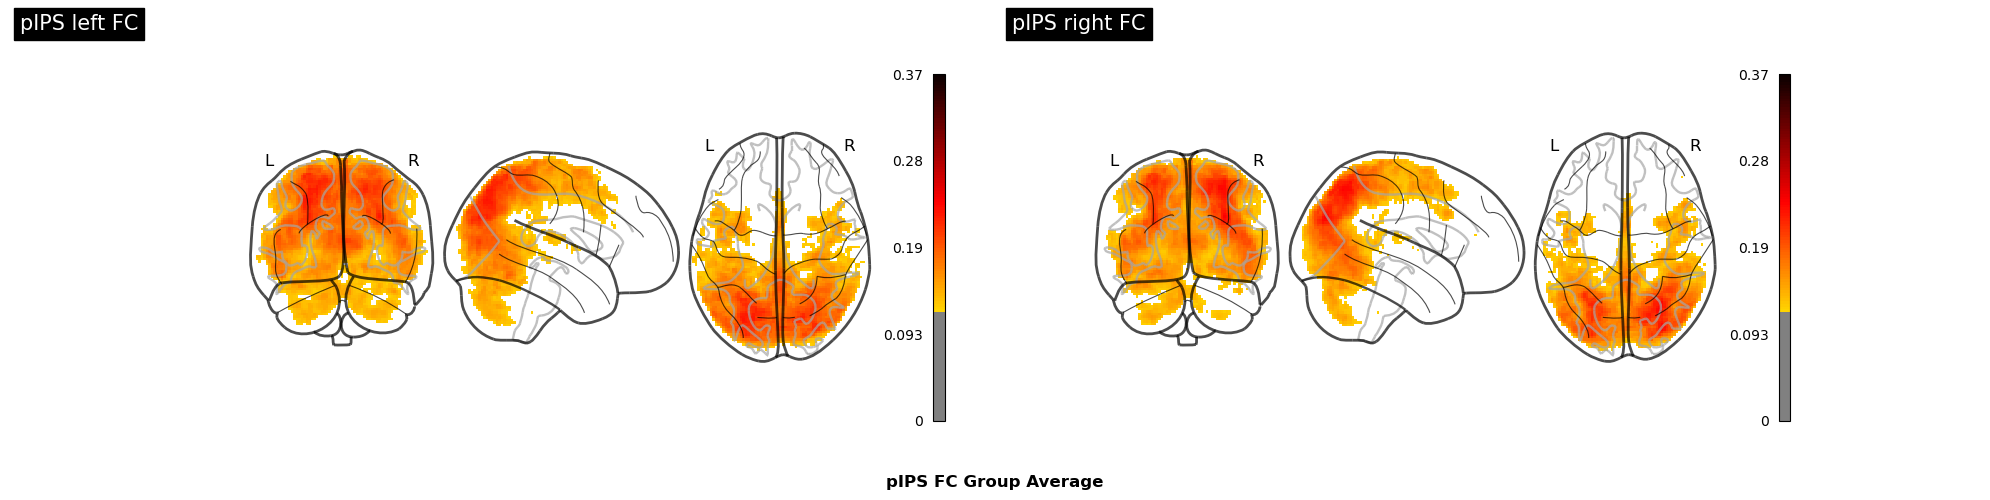

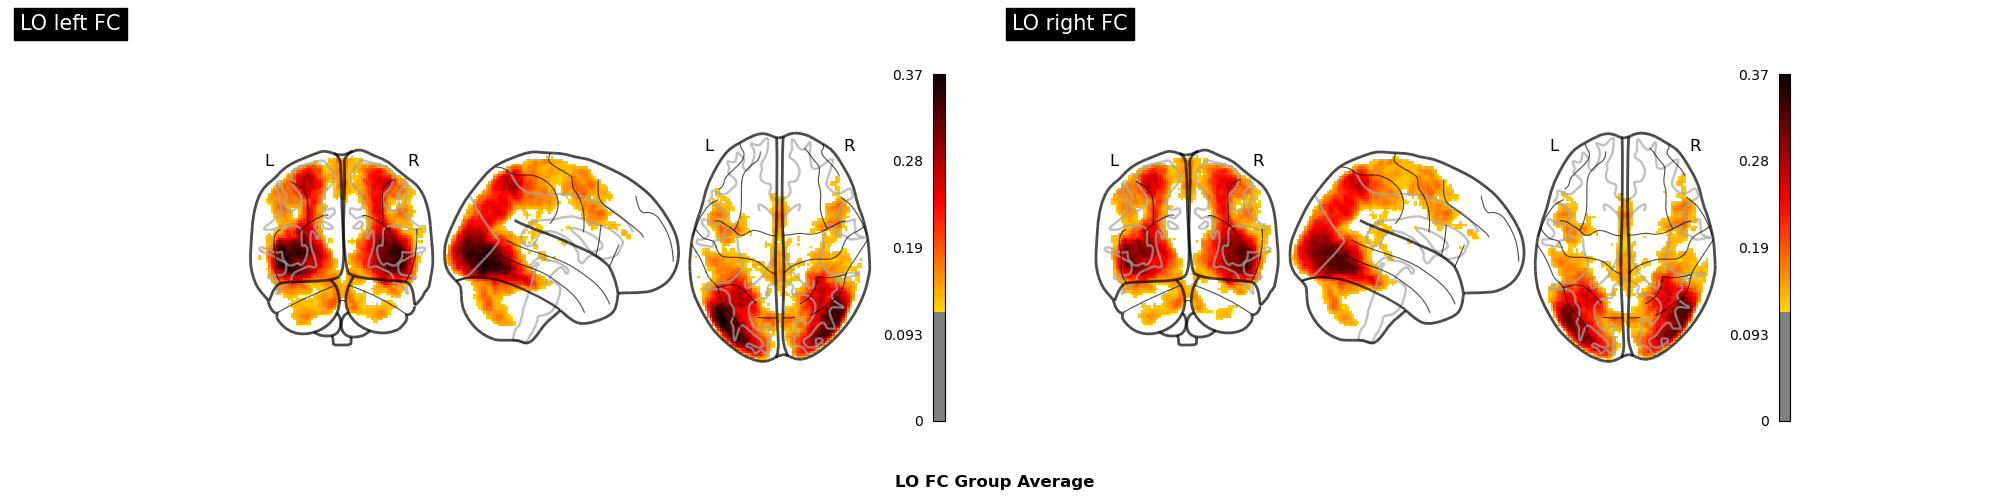

In [4]:
##group average with hemisphere object

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Explicitly set the path to sub_info.csv
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'  # Adjust this path as needed

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    img_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemi}_loc_{analysis_type}_mni.nii.gz'
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # First pass to determine global max across all ROIs
    global_vmax = 0
    for roi in rois:
        for analysis_type in ['fc']:  # ['fc', 'ppi']
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    img = nib.load(img_file)
                    data = img.get_fdata()
                    global_vmax = max(global_vmax, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['fc']:  # ['fc', 'ppi']
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Plot for each hemisphere
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=0.12, 
                        colorbar=True,
                        vmax=global_vmax, 
                        vmin=-global_vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i]
                    )
                    print(f"Created plot for {roi} {hemi} {analysis_type}")
                else:
                    print(f"Image file not found for {roi} {hemi} {analysis_type}")
            
            plt.tight_layout()
            
            # Add title at the bottom
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            # Adjust subplot positions to make room for the bottom title
            plt.subplots_adjust(bottom=0.15)
            
            #fig.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close(fig)

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

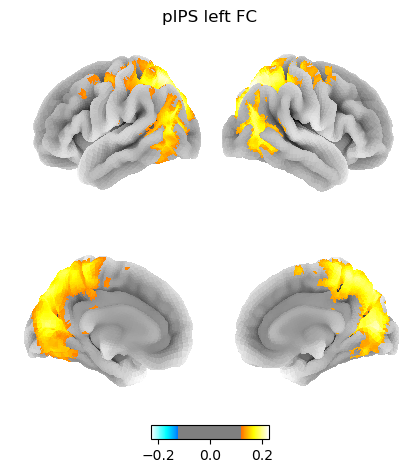

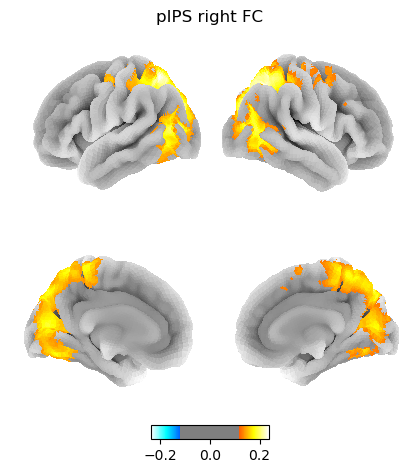

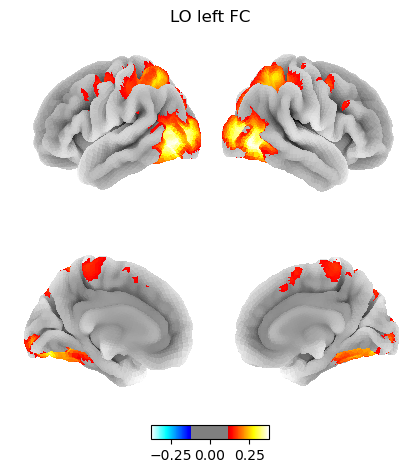

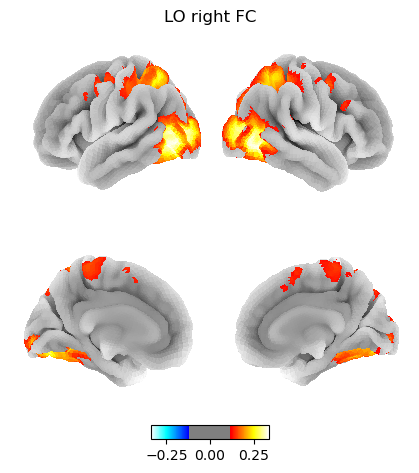

In [ ]:
# fc inflated brain - nilearn cortical surface
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

def plot_inflated_brains(out_dir, rois, hemispheres):
    # First pass to determine global max across all ROIs
    global_vmax = 0
    for roi in rois:
        for analysis_type in ['fc']:  
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    img = nib.load(img_file)
                    data = img.get_fdata()
                    global_vmax = max(global_vmax, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['fc']:
            # Create a figure for each ROI
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    # Create inflated surface plot
                    display = plotting.plot_img_on_surf(
                        img_file,
                        threshold=0.12,
                        colorbar=True,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        views=['lateral', 'medial']  # Show both lateral and medial views
                    )
                    
                    # Save the figure
                    output_path = f'{out_dir}/{roi}_{hemi}_{analysis_type}_inflated.png'
                    #plt.savefig(output_path, dpi=300, bbox_inches='tight')
                    #plt.close()
                    plt.show()
                    #print(f"Saved inflated visualization for {roi} {hemi}")

def main():
    # Define paths from your original script
    study = 'ptoc'
    study_dir = f"/lab_data/behrmannlab/vlad/{study}"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']

    # Plot inflated brains
    plot_inflated_brains(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()


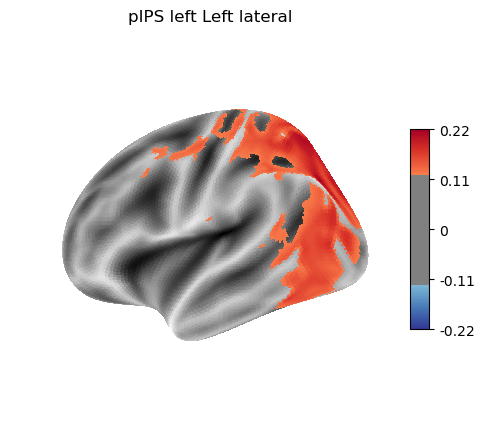

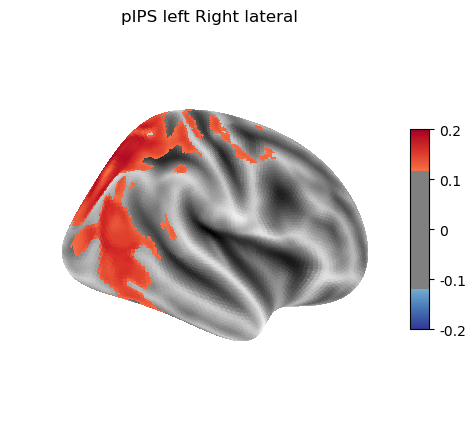

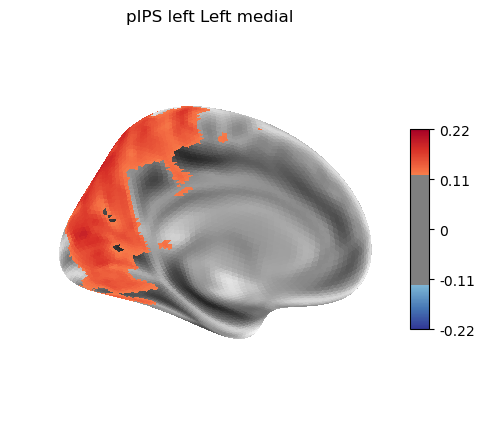

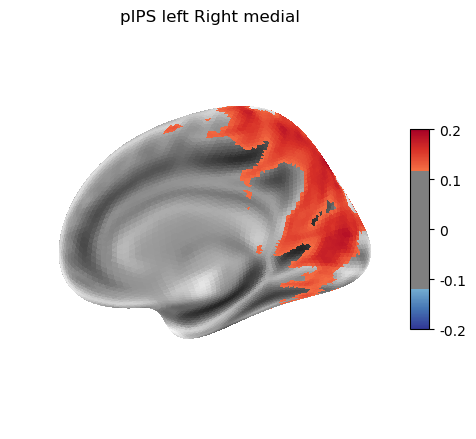

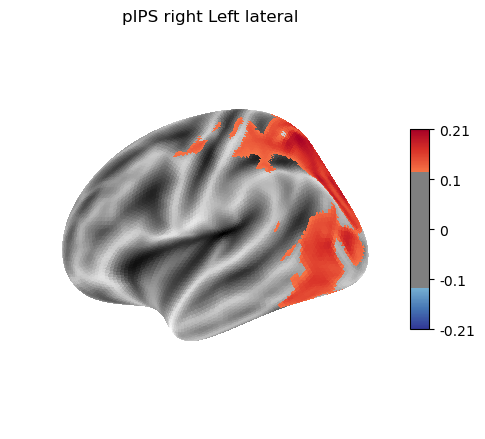

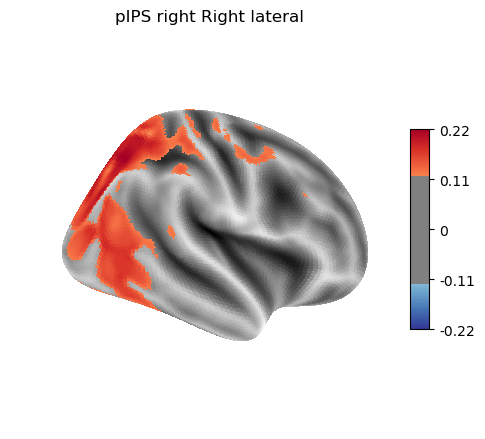

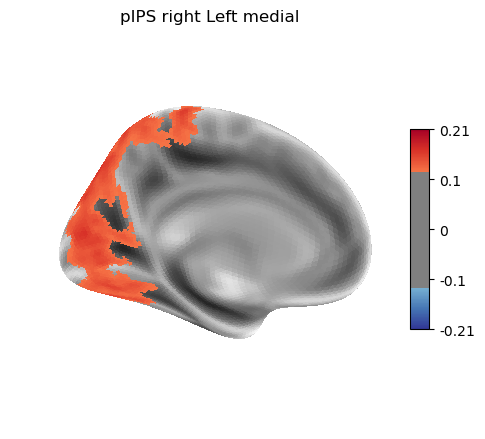

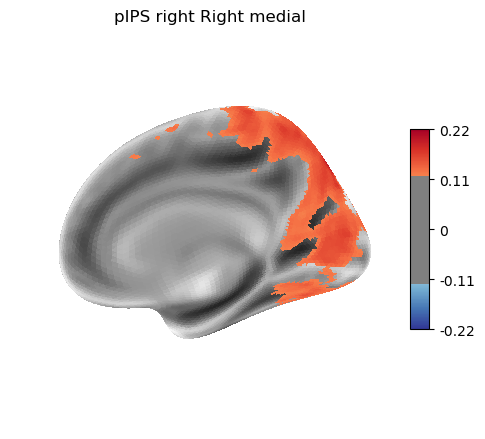

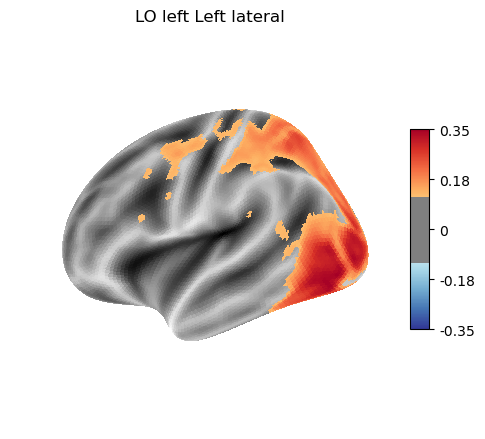

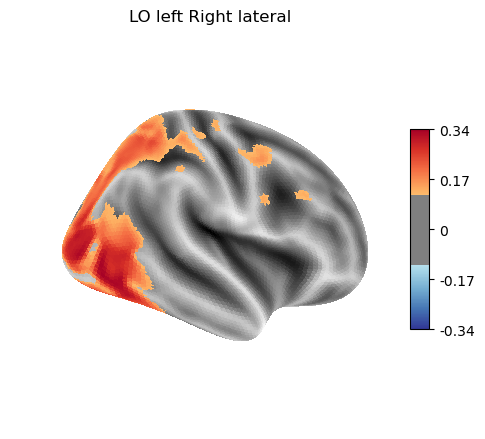

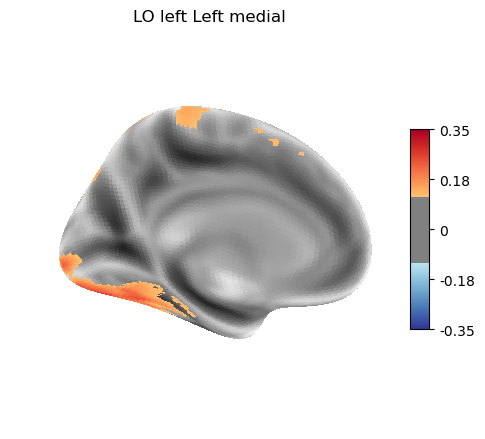

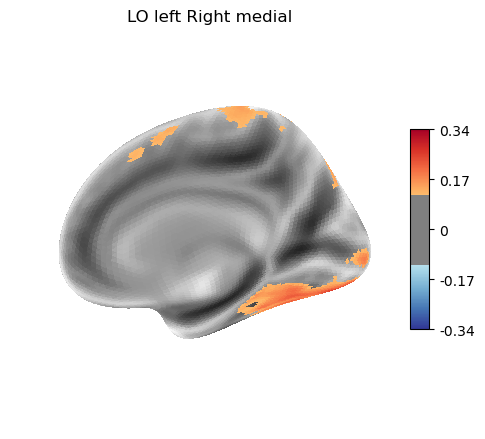

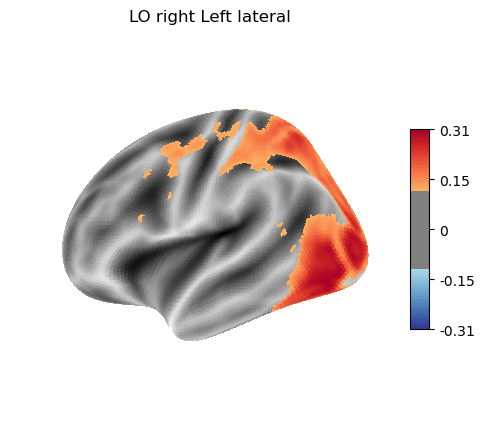

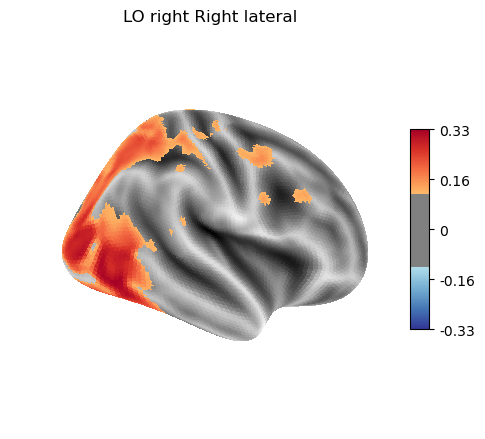

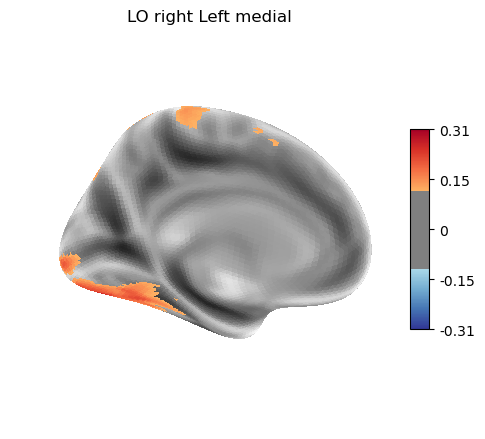

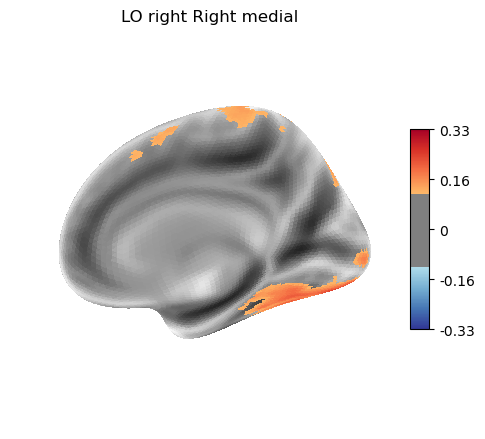

In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets, surface
import matplotlib.pyplot as plt

def plot_surface_brains(out_dir, rois, hemispheres):
    # Fetch the fsaverage surface for plotting
    fsaverage = datasets.fetch_surf_fsaverage()
    
    for roi in rois:
        for analysis_type in ['fc']:
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    # Load volume
                    img = nib.load(img_file)
                    
                    # Project the volume data to the surfaces
                    surf_data_left = surface.vol_to_surf(img, fsaverage.pial_left)
                    surf_data_right = surface.vol_to_surf(img, fsaverage.pial_right)
                    
                    # Create separate plots for different views
                    for view in ['lateral', 'medial']:
                        # Plot left hemisphere
                        plotting.plot_surf_stat_map(
                            surf_mesh=fsaverage.infl_left,
                            stat_map=surf_data_left,
                            hemi='left',
                            view=view,
                            threshold=0.12,
                            bg_map=fsaverage.sulc_left,
                            colorbar=True,
                            cmap='RdYlBu_r',
                            title=f'{roi} {hemi} Left {view}'
                        )
                        plt.show()
                        
                        # Plot right hemisphere
                        plotting.plot_surf_stat_map(
                            surf_mesh=fsaverage.infl_right,
                            stat_map=surf_data_right,
                            hemi='right',
                            view=view,
                            threshold=0.12,
                            bg_map=fsaverage.sulc_right,
                            colorbar=True,
                            
                            ='RdYlBu_r',
                            title=f'{roi} {hemi} Right {view}'
                        )
                        plt.show()

def main():
    # Define paths from your original script
    study = 'ptoc'
    study_dir = f"/lab_data/behrmannlab/vlad/{study}"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']

    # Plot surface brains
    plot_surface_brains(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

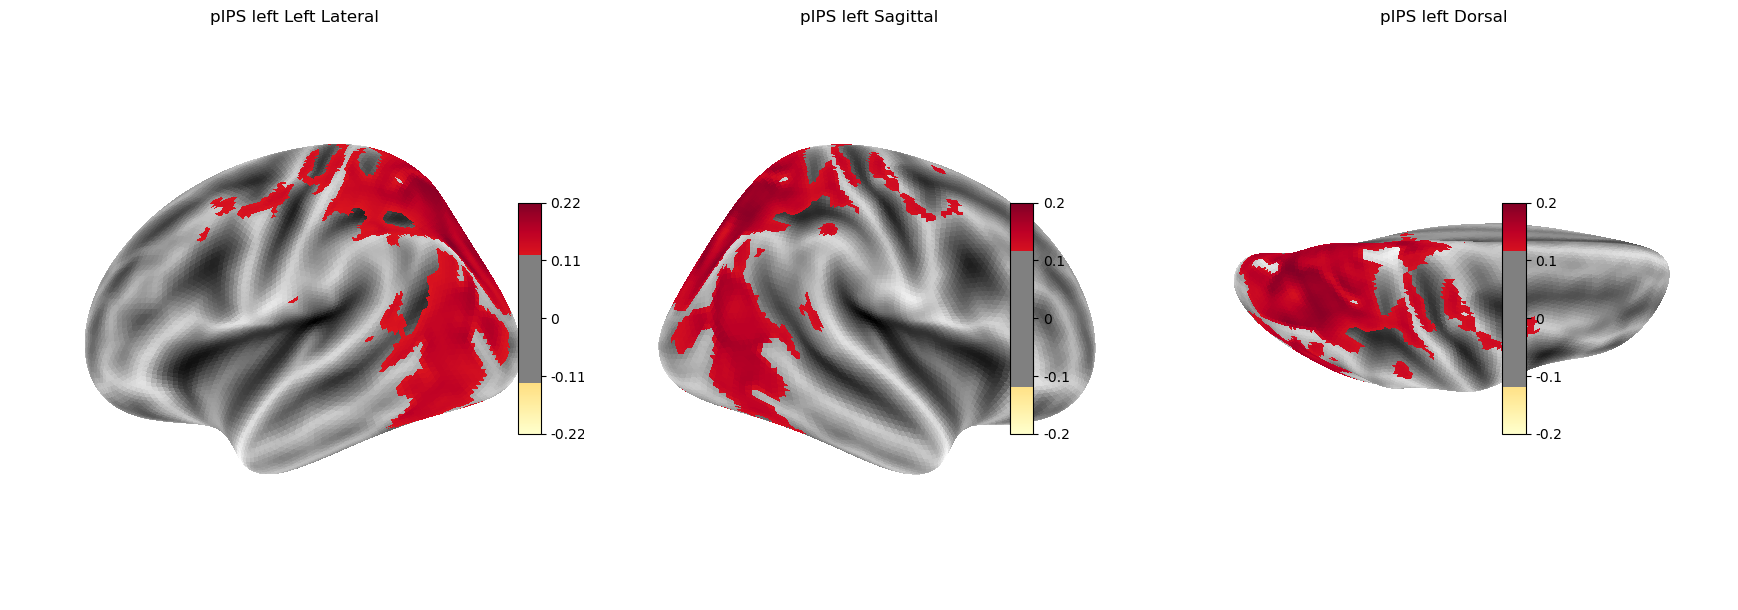

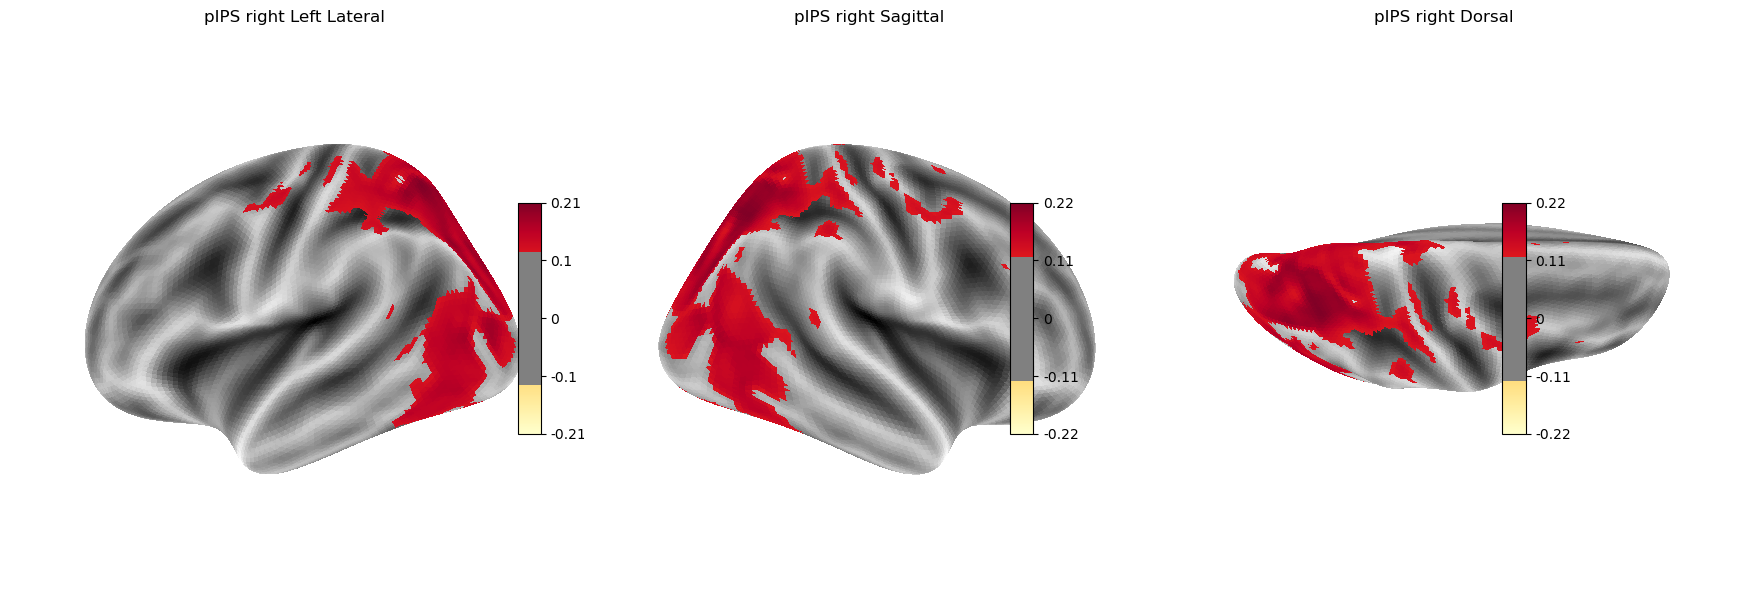

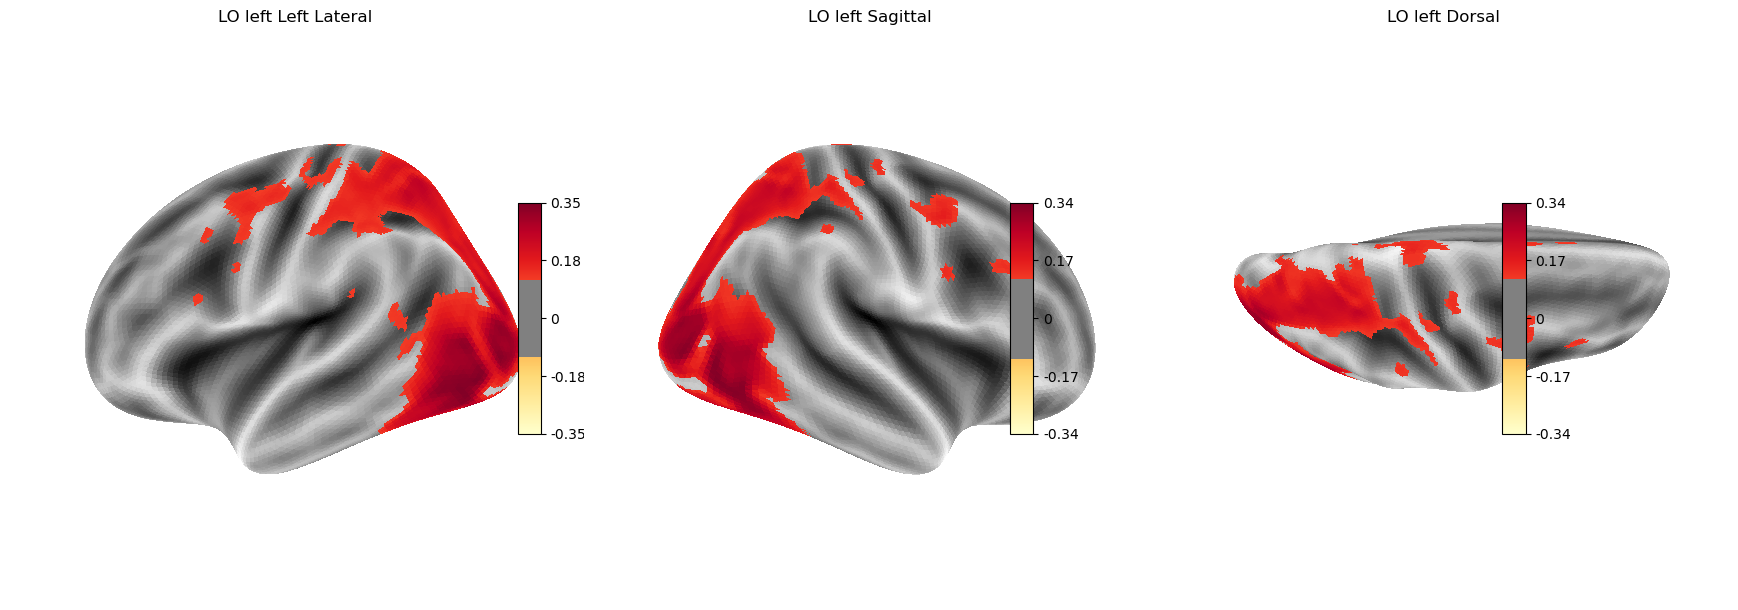

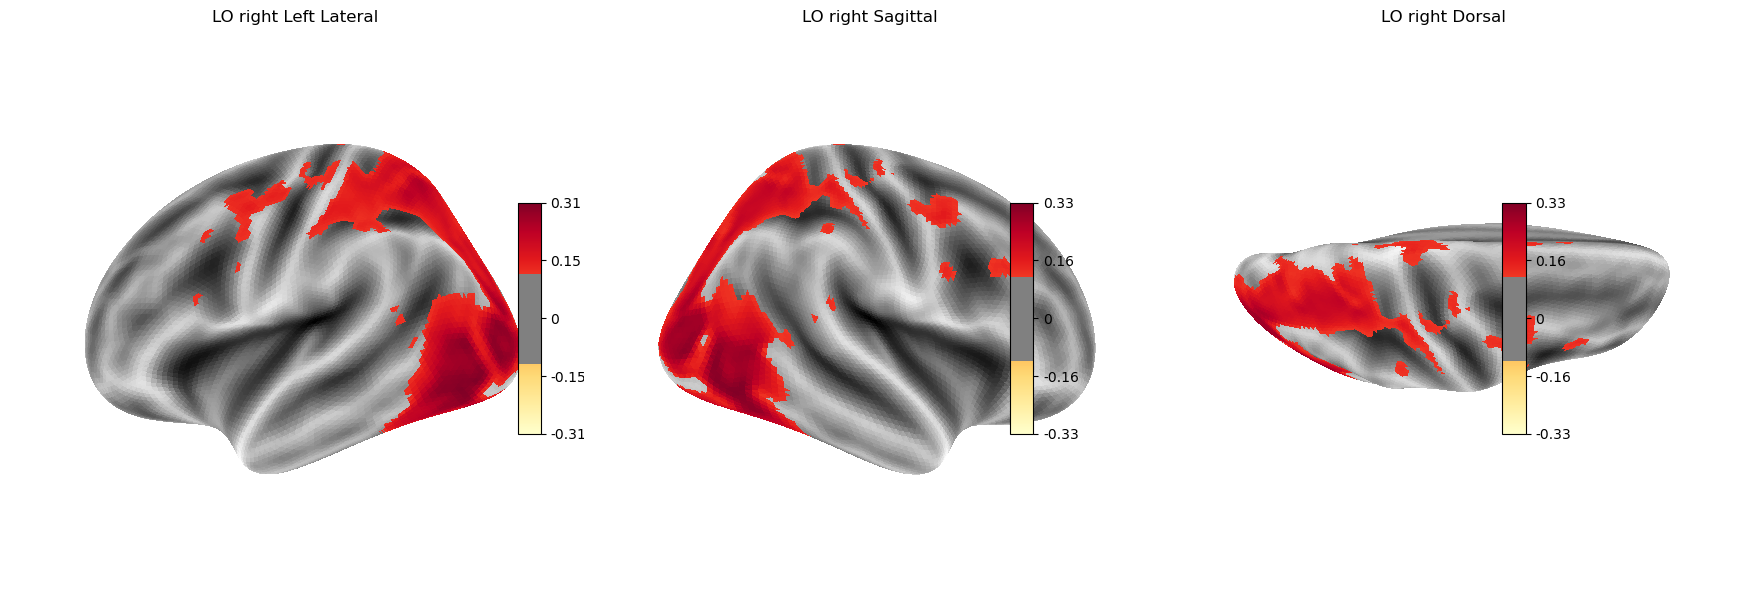

In [19]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets, surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is important for 3D plotting

def plot_surface_brains(out_dir, rois, hemispheres, threshold=0.12):
    # Fetch the fsaverage surface for plotting
    fsaverage = datasets.fetch_surf_fsaverage()
    
    for roi in rois:
        for analysis_type in ['fc']:
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    # Load volume
                    img = nib.load(img_file)
                    
                    # Project the volume data to the surfaces
                    surf_data_left = surface.vol_to_surf(img, fsaverage.pial_left)
                    surf_data_right = surface.vol_to_surf(img, fsaverage.pial_right)
                    
                    # Create figure with three subplots
                    fig = plt.figure(figsize=(18, 6))
                    
                    # Plot left lateral view
                    ax1 = fig.add_subplot(131, projection='3d')
                    plotting.plot_surf_stat_map(
                        surf_mesh=fsaverage.infl_left,
                        stat_map=surf_data_left,
                        hemi='left',
                        view='lateral',
                        threshold=threshold,
                        bg_map=fsaverage.sulc_left,
                        colorbar=True,
                        cmap='YlOrRd',
                        axes=ax1,
                        title=f'{roi} {hemi} Left Lateral'
                    )
                    
                    # Plot sagittal view
                    ax2 = fig.add_subplot(132, projection='3d')
                    plotting.plot_surf_stat_map(
                        surf_mesh=fsaverage.infl_right,
                        stat_map=surf_data_right,
                        hemi='right',
                        view='lateral',
                        threshold=threshold,
                        bg_map=fsaverage.sulc_right,
                        colorbar=True,
                        cmap='YlOrRd',
                        axes=ax2,
                        title=f'{roi} {hemi} Sagittal'
                    )
                    
                    # Plot dorsal view
                    ax3 = fig.add_subplot(133, projection='3d')
                    plotting.plot_surf_stat_map(
                        surf_mesh=fsaverage.infl_right,
                        stat_map=surf_data_right,
                        hemi='right',
                        view='dorsal',
                        threshold=threshold,
                        bg_map=fsaverage.sulc_right,
                        colorbar=True,
                        cmap='YlOrRd',
                        axes=ax3,
                        title=f'{roi} {hemi} Dorsal'
                    )
                    
                    plt.tight_layout()
                    plt.show()

def main():
    study = 'ptoc'
    study_dir = f"/lab_data/behrmannlab/vlad/{study}"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    plot_surface_brains(group_out_dir, rois, hemispheres, threshold=0.12)

if __name__ == "__main__":
    main()

Created plot for pIPS left ppi
Created plot for pIPS right ppi
Created plot for LO left ppi
Created plot for LO right ppi


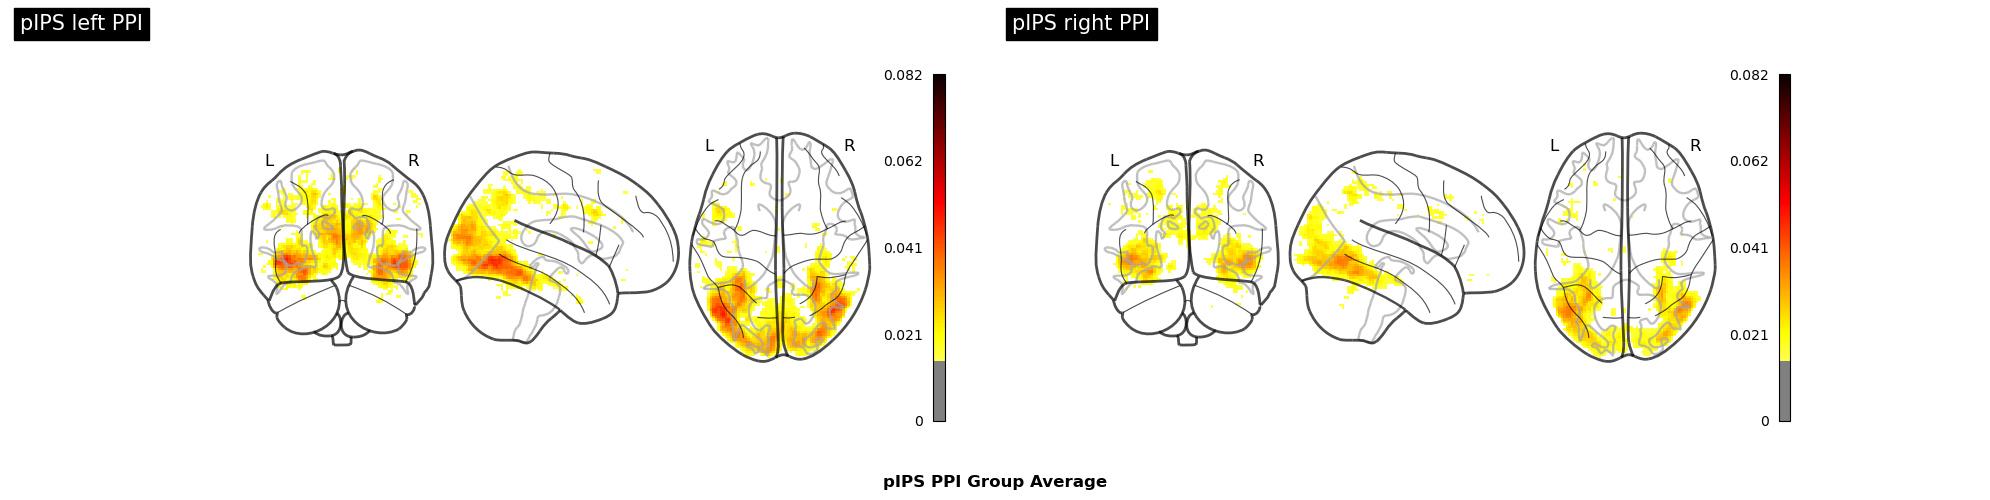

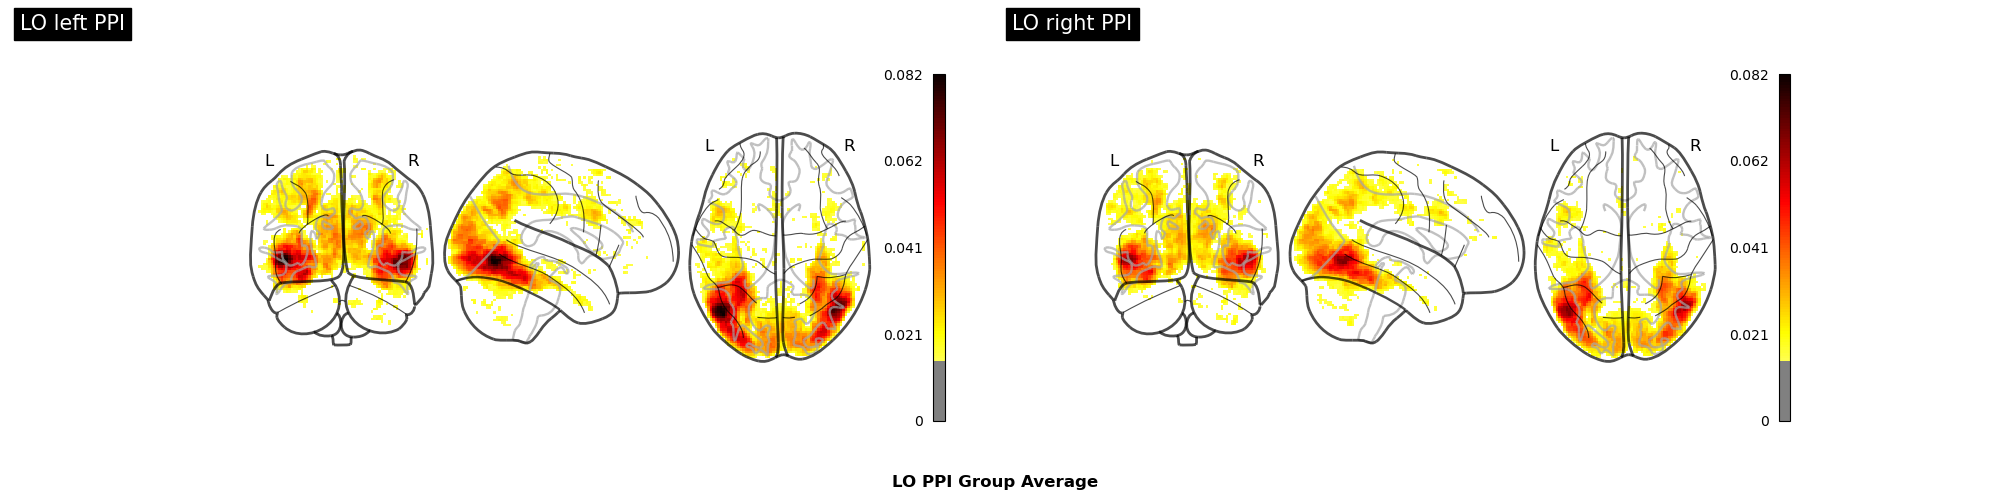

In [ ]:
# group average PPI FC plot
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Explicitly set the path to sub_info.csv
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'  # Adjust this path as needed

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']

def plot_group_averages(out_dir, rois, hemispheres):
    # First pass to determine global max across all ROIs
    global_vmax = 0
    for roi in rois:
        for analysis_type in ['ppi']:
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    img = nib.load(img_file)
                    data = img.get_fdata()
                    global_vmax = max(global_vmax, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Plot for each hemisphere
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=0.015,  # Keep the original threshold for PPI
                        colorbar=True,
                        vmax=global_vmax, 
                        vmin=-global_vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i]
                    )
                    print(f"Created plot for {roi} {hemi} {analysis_type}")
                else:
                    print(f"Image file not found for {roi} {hemi} {analysis_type}")
            
            plt.tight_layout()
            
            # Add title at the bottom
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            # Adjust subplot positions to make room for the bottom title
            plt.subplots_adjust(bottom=0.15)
            
            #fig.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close(fig)

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

Created plots for PFS left ppi
Created plots for PFS right ppi
Created plots for aIPS left ppi
Created plots for aIPS right ppi
Created plots for pIPS left ppi
Created plots for pIPS right ppi
Created plots for LO left ppi
Created plots for LO right ppi


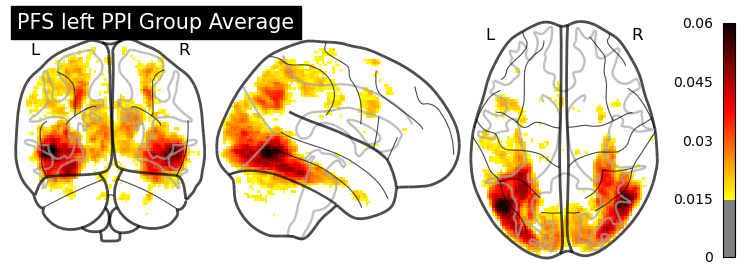

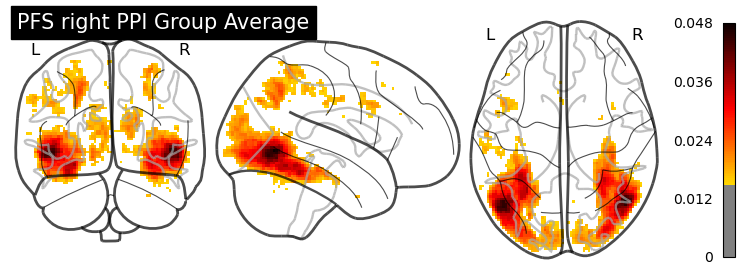

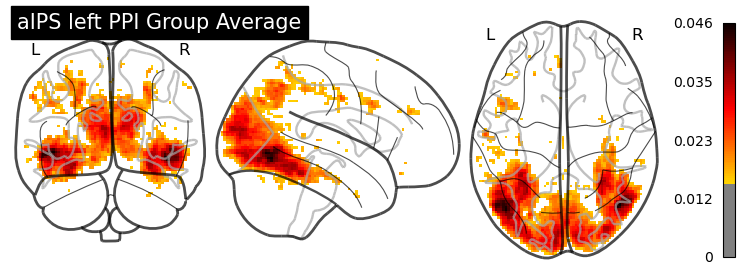

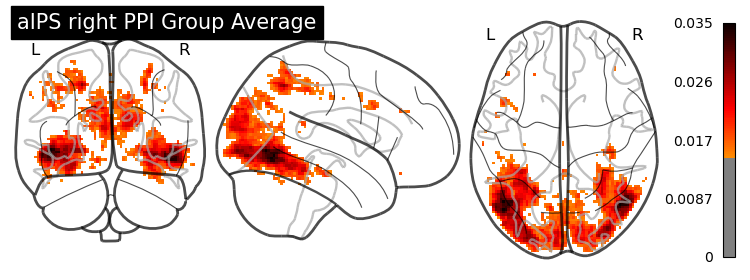

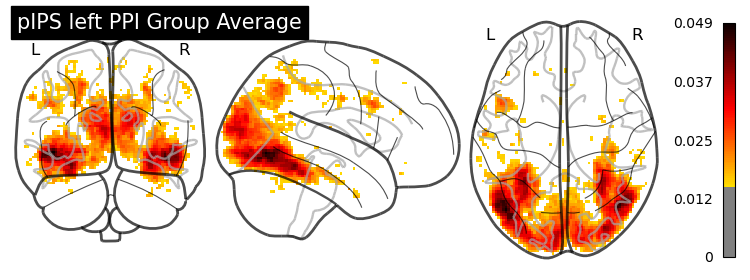

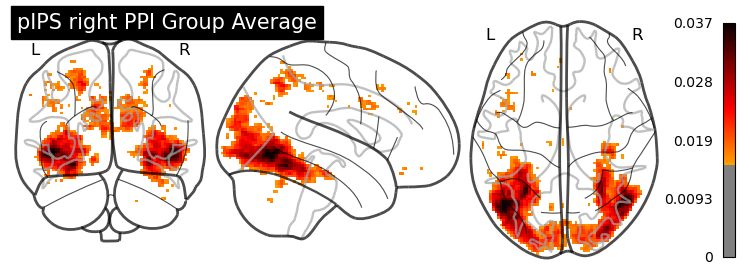

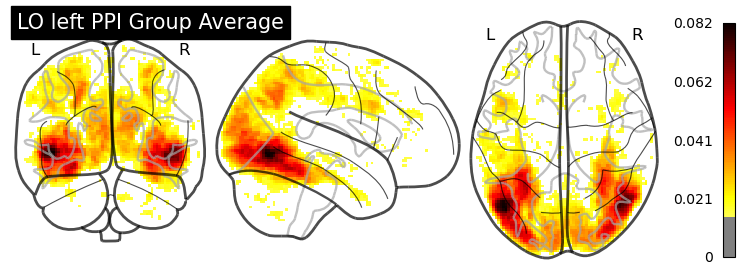

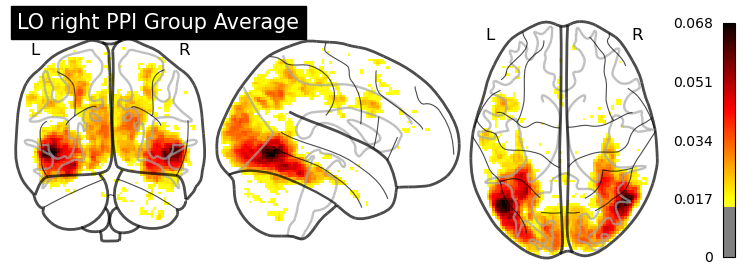

In [7]:
#plot PPI with hemispheres

import os
import numpy as np
import nibabel as nib
from nilearn import image, plotting

# Define study directories
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
#rois = ['PFS', 'aIPS', 'pIPS', 'LO']  # Add more ROIs as needed
rois = ['pIPS', 'LO']

hemispheres = ['left', 'right']


def plot_group_averages(out_dir, rois, hemispheres):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['ppi']:  # ['fc', 'ppi']
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    # Plot on glass brain
                    plot = plotting.plot_glass_brain(img_file, threshold=0.015, colorbar=True,
                                                    title=f'{roi} {hemi} {analysis_type.upper()} Group Average')
                    plot.savefig(f'{out_dir}/{roi}_{hemi}_{analysis_type}_glass_brain.png')
                    
                    # Plot on MNI152 template
                    # plot = plotting.plot_stat_map(img_file, threshold=0.12, colorbar=True,
                    #                               title=f'{roi} {hemi} {analysis_type.upper()} Group Average')
                    # plot.savefig(f'{out_dir}/{roi}_{hemi}_{analysis_type}_mni152.png')
                    
                    print(f"Created plots for {roi} {hemi} {analysis_type}")
                else:
                    print(f"Image file not found for {roi} {hemi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [ ]:
# group average and plot fc
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
subs = ['sub-025', 'sub-038', 'sub-107']
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def create_group_averages(subs, rois, out_dir):
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            all_sub_imgs = []
            for sub in subs:
                img_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_loc_{analysis_type}_mni.nii.gz'
                if os.path.exists(img_file):
                    all_sub_imgs.append(image.load_img(img_file))
                else:
                    print(f"Warning: File not found for {sub}, {roi}, {analysis_type}")
            
            if all_sub_imgs:
                avg_img = image.mean_img(all_sub_imgs)
                out_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
                nib.save(avg_img, out_file)
                print(f"Saved group average for {roi} {analysis_type}")
            else:
                print(f"No images found for {roi} {analysis_type}")

def plot_group_averages(out_dir, rois):
    for roi in rois:
        for analysis_type in ['fc']: #['fc', 'ppi']
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Plot on glass brain
                plot = plotting.plot_glass_brain(img_file, threshold=.1, colorbar=True, 
                                                 title=f'{roi} {analysis_type.upper()} Group Average')
                plot.savefig(f'{out_dir}/{roi}_{analysis_type}_glass_brain.png')
                
                # Plot on MNI152 template
                #plot = plotting.plot_stat_map(img_file, threshold=.12, colorbar=True, 
                                              #title=f'{roi} {analysis_type.upper()} Group Average')
                #plot.savefig(f'{out_dir}/{roi}_{analysis_type}_mni152.png')
                
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    # Create group averages
    create_group_averages(subs, rois, group_out_dir)
    
    # Plot group averages
    plot_group_averages(group_out_dir, rois)

if __name__ == "__main__":
    main()

Saved group average for pIPS fc
Saved group average for pIPS ppi
Saved group average for LO fc
Saved group average for LO ppi
Created plots for pIPS ppi
Image file not found for pIPS ppi
Created plots for pIPS ppi


KeyboardInterrupt: 

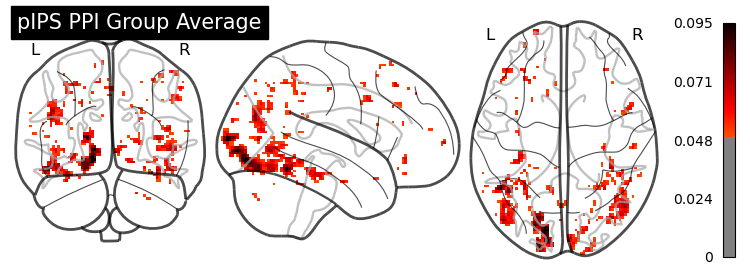

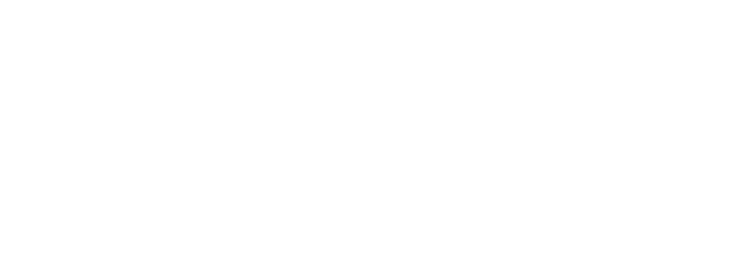

In [3]:
# plot ppi
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
subs = ['sub-025']
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def create_group_averages(subs, rois, out_dir):
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            all_sub_imgs = []
            for sub in subs:
                img_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_loc_{analysis_type}_mni.nii.gz'
                if os.path.exists(img_file):
                    all_sub_imgs.append(image.load_img(img_file))
                else:
                    print(f"Warning: File not found for {sub}, {roi}, {analysis_type}")
            
            if all_sub_imgs:
                avg_img = image.mean_img(all_sub_imgs)
                out_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
                nib.save(avg_img, out_file)
                print(f"Saved group average for {roi} {analysis_type}")
            else:
                print(f"No images found for {roi} {analysis_type}")

def plot_group_averages(out_dir, rois):
    for roi in rois:
        for analysis_type in ['ppi']: 
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Plot on glass brain
                plot = plotting.plot_glass_brain(img_file, threshold=0.05, colorbar=True, 
                                                 title=f'{roi} {analysis_type.upper()} Group Average')
                plot.savefig(f'{out_dir}/{roi}_{analysis_type}_glass_brain.png')     
                           
                print(f"Created plots for {roi} {analysis_type}")
                
                print(f"Image file not found for {roi} {analysis_type}")

                # Plot on MNI152 template
                #plot = plotting.plot_stat_map(img_file, threshold=.012, colorbar=True, 
                                              #title=f'{roi} {analysis_type.upper()} Group Average')
                #plot.savefig(f'{out_dir}/{roi}_{analysis_type}_mni152.png')
                
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    # Create group averages
    create_group_averages(subs, rois, group_out_dir)
    
    # Plot group averages
    plot_group_averages(group_out_dir, rois)

if __name__ == "__main__":
    main()

In [ ]:
#plot interactive surf
import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import nibabel as nib
from IPython.display import display

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'

# Define subjects and ROIs
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['V1', 'aIPS', 'LO']  # Add more ROIs as needed

def plot_group_averages(out_dir, rois):
    surface_plots = {}
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Interactive surface plot
                surface_plot = plotting.view_img_on_surf(img_file, threshold='90%', colorbar=True, 
                                                         title=f'{roi} {analysis_type.upper()} Group Average')
                surface_plots[f'{roi}_{analysis_type}'] = surface_plot
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")
    return surface_plots

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages and return surface plots
    surface_plots = plot_group_averages(group_out_dir, rois)
    return surface_plots

# Run the main function and get the surface plots
surface_plots = main()

# Display the surface plots
for plot_name, plot in surface_plots.items():
    #print(f"Displaying {plot_name}")
    display(plot)

In [ ]:
#plot interactive surf
import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import nibabel as nib
from IPython.display import display

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'

# Define subjects and ROIs
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def plot_group_averages(out_dir, rois):
    surface_plots = {}
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Interactive surface plot
                surface_plot = plotting.view_img_on_surf(img_file, threshold='90%', colorbar=True, 
                                                         title=f'{roi} {analysis_type.upper()} Group Average')
                surface_plots[f'{roi}_{analysis_type}'] = surface_plot
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")
    return surface_plots

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages and return surface plots
    surface_plots = plot_group_averages(group_out_dir, rois)
    return surface_plots

# Run the main function and get the surface plots
surface_plots = main()

# Display the surface plots
for plot_name, plot in surface_plots.items():
    #print(f"Displaying {plot_name}")
    display(plot)

In [ ]:
# create csv of seed target activations
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time

# Import parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
analyses = ['fc', 'ppi']
tasks = ['loc']

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def process_subjects():
    results = []
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # Load ROI coordinates
        roi_dir = f'{study_dir}/{subject}/ses-01/derivatives/rois'
        roi_coords = pd.read_csv(f'{roi_dir}/spheres/sphere_coords_hemisphere.csv')
        
        # Create ROI maskers for target ROIs (LO)
        target_maskers = {}
        for hemisphere in hemispheres:
            for task in tasks:
                curr_coords = roi_coords[
                    (roi_coords['task'] == task) & 
                    (roi_coords['roi'] == 'LO') &
                    (roi_coords['hemisphere'] == hemisphere)
                ]
                
                if curr_coords.empty:
                    print(f"No coordinates found for {subject}, LO, {hemisphere}, {task}")
                    continue
                
                coords = curr_coords[['x', 'y', 'z']].values.tolist()[0]
                target_maskers[(hemisphere, task)] = create_roi_masker(coords)
        
        # Process each analysis
        for analysis in analyses:
            results_dir = os.path.join(study_dir, subject, 'ses-01', 'derivatives', 'fc')
            
            # Use pIPS as seed
            for seed_hemisphere in hemispheres:
                for task in tasks:
                    seed_file = f"{subject}_pIPS_{seed_hemisphere}_{task}_{analysis}.nii.gz"
                    full_seed_path = os.path.join(results_dir, seed_file)
                    
                    if not os.path.exists(full_seed_path):
                        print(f"No {analysis} results file found for {subject}, pIPS, {seed_hemisphere}, {task}")
                        continue
                    
                    # Load the seed results image
                    seed_img = nib.load(full_seed_path)
                    
                    # Extract mean activation in target ROIs (LO)
                    for target_hemisphere in hemispheres:
                        target_masker = target_maskers.get((target_hemisphere, task))
                        if target_masker is None:
                            print(f"No target masker found for {subject}, LO, {target_hemisphere}, {task}")
                            continue
                        
                        # Extract mean activation
                        mean_activation = extract_mean_activation(seed_img, target_masker)
                        
                        # Store the results
                        results.append({
                            'subject': subject,
                            'seed_roi': 'pIPS',
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    output_file = os.path.join(results_dir, 'matchvlad_seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Run the processing
if __name__ == "__main__":
    process_subjects()